# Dataset download

https://warwick.ac.uk/fac/cross_fac/tia/data/glascontest/about/

In [ ]:
# # download file from https://warwick.ac.uk/fac/cross_fac/tia/data/glascontest/download
!wget https://warwick.ac.uk/fac/cross_fac/tia/data/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip
# extract zip-file
!unzip -qq "warwick_qu_dataset_released_2016_07_08.zip"

In [ ]:
!ls "Warwick QU Dataset (Released 2016_07_08)"

In [ ]:
import os # to use makedirs for create directory
import shutil # copy, move file or directory 
from glob import glob # grap expected files
from natsort import natsorted # natural sorting

# mask
train_mask = natsorted(glob('Warwick QU Dataset (Released 2016_07_08)/train*_anno.bmp'))
path = 'Warwick QU Dataset (Released 2016_07_08)/train/mask/'
os.makedirs(path, exist_ok=True)
for t in train_mask:
    src = t
    dst = f'{path}{t.split("/")[-1]}'
    shutil.move(src,dst)

# image
train_image = natsorted(glob('Warwick QU Dataset (Released 2016_07_08)/train*.bmp'))
path = 'Warwick QU Dataset (Released 2016_07_08)/train/image/'
os.makedirs(path, exist_ok=True)
for t in train_image:
    src = t
    dst = f'{path}{t.split("/")[-1]}'
    shutil.move(src,dst)

# mask
test_mask = natsorted(glob('Warwick QU Dataset (Released 2016_07_08)/test*_anno.bmp'))
path = 'Warwick QU Dataset (Released 2016_07_08)/test/mask/'
os.makedirs(path, exist_ok=True)
for t in test_mask:
    src = t
    dst = f'{path}{t.split("/")[-1]}'
    shutil.move(src,dst)

# image
test_image = natsorted(glob('Warwick QU Dataset (Released 2016_07_08)/test*.bmp'))
path = 'Warwick QU Dataset (Released 2016_07_08)/test/image/'
os.makedirs(path, exist_ok=True)
for t in test_image:
    src = t
    dst = f'{path}{t.split("/")[-1]}'
    shutil.move(src,dst)

In [ ]:
# build validation dataset from train dataset
from sklearn.model_selection import train_test_split

# mask
train_mask = natsorted(glob('Warwick QU Dataset (Released 2016_07_08)/train/mask/*.bmp'))
_,valid_mask = train_test_split(train_mask,test_size=0.1,shuffle=True,random_state=0)
path = 'Warwick QU Dataset (Released 2016_07_08)/valid/mask/'
os.makedirs(path, exist_ok=True)
for t in valid_mask:
    src = t
    dst = f'{path}{t.split("/")[-1]}'
    shutil.move(src,dst)

# image
train_image = natsorted(glob('Warwick QU Dataset (Released 2016_07_08)/train/image/*.bmp'))
_,valid_image = train_test_split(train_image,test_size=0.1,shuffle=True,random_state=0)
path = 'Warwick QU Dataset (Released 2016_07_08)/valid/image/'
os.makedirs(path, exist_ok=True)
for t in valid_image:
    src = t
    dst = f'{path}{t.split("/")[-1]}'
    shutil.move(src,dst)

# import library

In [1]:
!pip install livelossplot --quiet

import random,cv2
import os
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models

import torchvision.transforms as T
import torch.utils.data
from natsort import natsorted
from PIL import Image
import numpy as np
%matplotlib inline 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import patches

from time import time
from tqdm.notebook import tqdm

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

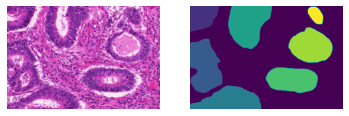

In [3]:
image = Image.open('Warwick QU Dataset (Released 2016_07_08)/train/image/train_1.bmp')
mask = Image.open('Warwick QU Dataset (Released 2016_07_08)/train/mask/train_1_anno.bmp')
plt.subplot(121)
plt.axis('off')
plt.imshow(image)
plt.subplot(122)
plt.axis('off')
plt.imshow(mask)
np.unique(mask)

In [4]:
class WarwickCellDataset(object):
    def __init__(self, root, transforms=None): # transforms
        self.root = root
        self.transforms=[]
        if transforms!=None:
            self.transforms.append(transforms)
            
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(natsorted(os.listdir(os.path.join(root, "image"))))
        self.masks = list(natsorted(os.listdir(os.path.join(root, "mask"))))
        print('imgs file names:\n', self.imgs)
        print('masks file names:\n', self.masks)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "image", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path) # with 0 being background, 1 ~ N are for different instance
        mask = np.array(mask)        # convert the PIL Image into a numpy array
        obj_ids = np.unique(mask)    # instances are encoded as different colors
        obj_ids = obj_ids[1:]        # first id is the background, so remove it

        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            A = abs((xmax-xmin) * (ymax-ymin)) 
            
            # Check if area is larger than a threshold (here 5)
            if A < 5:
                obj_ids=np.delete(obj_ids, [i])
                continue

            boxes.append([xmin, ymin, xmax, ymax])

        num_objs = len(obj_ids)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)     # convert everything into a torch.Tensor
        labels = torch.ones((num_objs,), dtype=torch.int64)     # there is only one class
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        # area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        masks_original = torch.as_tensor(mask, dtype=torch.uint8)
        masks_original[masks_original!=0] = 1
        
        for i in self.transforms:
            img = i(img)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["masks_original"] = masks_original
        return img.double(), target

    def __len__(self):
        return len(self.imgs)

root_train = 'Warwick QU Dataset (Released 2016_07_08)/train'
root_valid = 'Warwick QU Dataset (Released 2016_07_08)/valid'
root_test = 'Warwick QU Dataset (Released 2016_07_08)/test'
dataset_train = WarwickCellDataset(root_train, transforms=torchvision.transforms.ToTensor()) # get_transform(train=True)
dataset_valid = WarwickCellDataset(root_valid, transforms=torchvision.transforms.ToTensor())
dataset_test = WarwickCellDataset(root_test, transforms=torchvision.transforms.ToTensor())

imgs file names:
 ['train_1.bmp', 'train_2.bmp', 'train_4.bmp', 'train_5.bmp', 'train_6.bmp', 'train_7.bmp', 'train_8.bmp', 'train_9.bmp', 'train_10.bmp', 'train_11.bmp', 'train_12.bmp', 'train_13.bmp', 'train_15.bmp', 'train_16.bmp', 'train_17.bmp', 'train_18.bmp', 'train_19.bmp', 'train_20.bmp', 'train_21.bmp', 'train_22.bmp', 'train_23.bmp', 'train_24.bmp', 'train_25.bmp', 'train_26.bmp', 'train_27.bmp', 'train_28.bmp', 'train_29.bmp', 'train_30.bmp', 'train_32.bmp', 'train_33.bmp', 'train_34.bmp', 'train_35.bmp', 'train_36.bmp', 'train_37.bmp', 'train_38.bmp', 'train_39.bmp', 'train_40.bmp', 'train_41.bmp', 'train_43.bmp', 'train_44.bmp', 'train_45.bmp', 'train_46.bmp', 'train_47.bmp', 'train_48.bmp', 'train_50.bmp', 'train_52.bmp', 'train_53.bmp', 'train_54.bmp', 'train_55.bmp', 'train_57.bmp', 'train_58.bmp', 'train_59.bmp', 'train_60.bmp', 'train_61.bmp', 'train_62.bmp', 'train_63.bmp', 'train_65.bmp', 'train_66.bmp', 'train_67.bmp', 'train_68.bmp', 'train_69.bmp', 'train_70.bmp

In [5]:
dataset_train[0]

(tensor([[[0.4039, 0.3882, 0.3725,  ..., 0.5686, 0.6510, 0.7882],
          [0.3882, 0.4118, 0.4471,  ..., 0.7137, 0.7529, 0.8078],
          [0.4078, 0.5059, 0.6000,  ..., 0.8353, 0.8392, 0.8431],
          ...,
          [0.4706, 0.5137, 0.5490,  ..., 0.6902, 0.7882, 0.8667],
          [0.5804, 0.5686, 0.5961,  ..., 0.7608, 0.8157, 0.8902],
          [0.6353, 0.6471, 0.6549,  ..., 0.8039, 0.8667, 0.8941]],
 
         [[0.1059, 0.0980, 0.0784,  ..., 0.1333, 0.1725, 0.2471],
          [0.0824, 0.1059, 0.1333,  ..., 0.2000, 0.2235, 0.2471],
          [0.0902, 0.1569, 0.2275,  ..., 0.2824, 0.2588, 0.2392],
          ...,
          [0.1451, 0.1725, 0.2078,  ..., 0.2196, 0.2510, 0.2902],
          [0.2118, 0.1843, 0.2118,  ..., 0.2510, 0.2510, 0.2980],
          [0.2392, 0.2627, 0.2784,  ..., 0.2667, 0.2902, 0.3020]],
 
         [[0.5137, 0.5137, 0.5059,  ..., 0.5647, 0.5961, 0.6941],
          [0.4980, 0.5059, 0.5255,  ..., 0.6275, 0.6314, 0.7098],
          [0.5098, 0.5255, 0.5647,  ...,

In [10]:
# Define data loader
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=2, num_workers=2, shuffle=True, collate_fn=lambda x:list(zip(*x)))
data_loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=2, num_workers=1, shuffle=False, collate_fn=lambda x:list(zip(*x)))
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=lambda x:list(zip(*x)))
print(len(data_loader_train),len(data_loader_valid),len(data_loader_test))

# collate_fn=lambda x:list(zip(*x)) is for variant ROIs
# data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=2, num_workers=2, shuffle=True) # <-- this will have error when we run following steps

38 5 80


# Exploratory data analysis

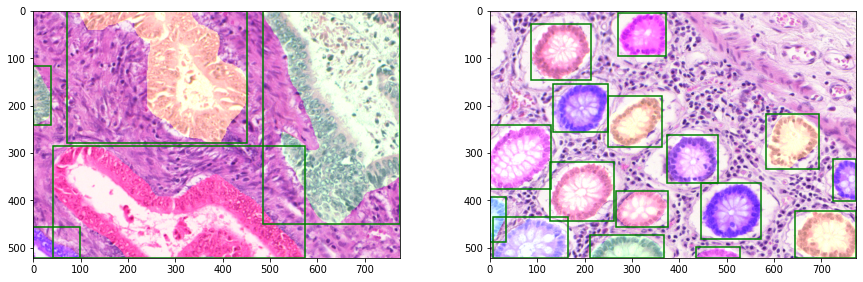

In [11]:
# View some images and their bbox's in the training set.
images,labels=next(iter(data_loader_train))

def random_colour_masks(image):
    """
    for visualizing instance segmentation
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=-1)
    return coloured_mask

def apply_nms(labels, boxes, masks, scores, iou_thresh=0.5):
    """
    Non-maximum suppression (NMS) using torchvision
    it works on a single target
    """
    keep = torchvision.ops.nms(boxes, scores, iou_thresh)  # torchvision returns the indices of the bboxes to keep
    
    labels = labels[keep]
    boxes = boxes[keep]
    masks = masks[keep]
    scores = scores[keep]
    return labels, boxes, masks, scores

def view(images, annos, score_threshold=0.5, nms_iou_threshold = 0.5, n=2, std=1, mean=0):
    """
    view image, label, result for object detection
    score_threshold : remove boxes when confidence score is lower than the value
    nms_iou_threshold : remove duplicated boxes using NMS
    """
    figure = plt.figure(figsize=(15,10))
    images=list(images)
    annos=list(annos)
    
    for i in range(n):
        image=images[i].cpu().numpy().transpose((1,2,0)) # torch type to numpy type to show image using plt
        image=np.array(std)*image+np.array(mean)
        image=np.clip(image,0,1) * 255
        image=image.astype(np.uint8) 

        l=annos[i]['labels']
        b=annos[i]['boxes']
        m=annos[i]['masks']
        try:
            scores=annos[i]['scores']
            if nms_iou_threshold:
                l,b,m,scores = apply_nms(l, b, m, scores, nms_iou_threshold)
        except:
            scores = ["GT"]*len(b)
        
        if len(m.shape)==4:
            m=m[:,0]
        
        l = l.cpu().numpy()
        b = b.cpu().numpy()
        m = m.cpu().numpy()
        
        # mask likelihood to binary[0,1] 
        m[m>=.5]=1
        m[m<.5]=0
         
        # (X1,Y1,X2,Y2) to (X1,Y1,W,H)
        b[:,2]=b[:,2]-b[:,0]
        b[:,3]=b[:,3]-b[:,1]
        
        ax = figure.add_subplot(2,2, i + 1)
        for j in range(len(b)):
            if scores[j]=='GT' or scores[j]>score_threshold:
                ax.add_patch(patches.Rectangle((b[j][0],b[j][1]),b[j][2],b[j][3],linewidth=1.5,edgecolor='g',facecolor='none'))
                try:
                    ax.text(int(b[j][0]), int(b[j][1]), f"{scores[j]:.3f}", fontsize=10)
                except:
                    pass
                mask = random_colour_masks(m[j])
                image = cv2.addWeighted(image, 1, mask, 0.4, 0)
        ax.imshow(image)
    plt.show()
    
view(images=images,annos=labels, score_threshold=0, nms_iou_threshold=0, n=2, std=1, mean=0)

In [12]:
xs = []
ys = []
ratios = []
for idx,batch in enumerate(data_loader_train):
    img, target = batch
    # print(target)
    boxes = target[0]['boxes']
    for b in boxes:
        x_delta = b[2]-b[0]
        y_delta = b[3]-b[1]
        xs.append(x_delta)
        ys.append(y_delta)
        ratios.append(y_delta/x_delta)        
print('train dataset')
print(f'xs min {np.min(xs)}, max {np.max(xs)}, mean {np.mean(xs)}, median {np.median(xs)}')
print(f'ys min {np.min(ys)}, max {np.max(ys)}, mean {np.mean(ys)}, median {np.median(ys)}')
print(f'ratios min {np.min(ratios)}, max {np.max(ratios)}, mean {np.mean(ratios)}, median {np.median(ratios)}')

xs = []
ys = []
ratios = []
for idx,batch in enumerate(data_loader_valid):
    img, target = batch
    # print(target)
    boxes = target[0]['boxes']
    for b in boxes:
        x_delta = b[2]-b[0]
        y_delta = b[3]-b[1]
        xs.append(x_delta)
        ys.append(y_delta)
        ratios.append(y_delta/x_delta)
print('valid dataset')
print(f'xs min {np.min(xs)}, max {np.max(xs)}, mean {np.mean(xs)}, median {np.median(xs)}')
print(f'ys min {np.min(ys)}, max {np.max(ys)}, mean {np.mean(ys)}, median {np.median(ys)}')
print(f'ratios min {np.min(ratios)}, max {np.max(ratios)}, mean {np.mean(ratios)}, median {np.median(ratios)}')

train dataset
xs min 14.0, max 774.0, mean 187.4136962890625, median 130.5
ys min 10.0, max 521.0, mean 149.36904907226562, median 117.0
ratios min 0.12112676352262497, max 8.199999809265137, mean 1.074894905090332, median 0.8885438442230225
valid dataset
xs min 33.0, max 656.0, mean 194.5853729248047, median 126.0
ys min 29.0, max 521.0, mean 171.34146118164062, median 167.0
ratios min 0.22549019753932953, max 3.2750000953674316, mean 1.1912438869476318, median 0.8583333492279053


# Define Mask R-CNN, finetuning

In [13]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, RPNHead
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.anchor_utils import AnchorGenerator

# load an instance segmentation model pre-trained on COCO
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT") # torch >= 1.11 
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) # torch < 1.11
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False) # torch < 1.11
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

# Modify model for our task

In [15]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features    # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels # now get the number of input features for the mask classifier
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes) # and replace the mask predictor with a new one

anchor_sizes = ((32,), (64,), (128,), (256,), (512,),)
anchor_generator = AnchorGenerator(sizes = anchor_sizes, aspect_ratios = ((.125, .25, 0.5, 1.0, 2.0, 4.0, 8.0),) * len(anchor_sizes))
model.rpn.anchor_generator = anchor_generator

rpn_head = RPNHead(model.backbone.out_channels, anchor_generator.num_anchors_per_location()[0])
model.rpn.head = rpn_head

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model=model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.002, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
lr_scheduler.get_lr()


KeyboardInterrupt



In [ ]:
model

# Inference without training

In [ ]:
# check the performance of pretrained weight
images, targets=next(iter(data_loader_test))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model=model.double()
model.eval()

with torch.no_grad():
    outputs = model(images)
    view(images=images,annos=outputs, score_threshold=0, nms_iou_threshold=0, n=1, std=1, mean=0)

# Training

In [ ]:
from livelossplot import PlotLosses
plotlosses = PlotLosses()

# Perform training loop for n epochs
loss_train_epoch = []
loss_valid_epoch = []
n_epochs = 20

for epoch in tqdm(range(n_epochs),desc='training'):
    model.train()
    loss_train = []
    for images,targets in tqdm(data_loader_train,desc=f'train_epoch_{epoch}'):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        model=model.double()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()       
        optimizer.step()        
        loss_train.append(losses.item())
    lr_scheduler.step()
        
    # model.eval()
    loss_valid = []
    for images,targets in tqdm(data_loader_valid,desc=f'valid_epoch_{epoch}'):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model=model.double()
        with torch.no_grad():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_valid.append(losses.item())
    
    loss_train_mean = np.mean(loss_train) 
    loss_train_epoch.append(loss_train_mean)

    loss_valid_mean = np.mean(loss_valid) 
    loss_valid_epoch.append(loss_valid_mean)

    plotlosses.update({
    'loss': loss_train_mean,
    'val_loss': loss_valid_mean,
    'lr': lr_scheduler.get_lr()[0],
    })
    plotlosses.send()

    # Save model
    if loss_valid_epoch[-1] == np.min(loss_valid_epoch):
        save_path = 'weight.pt'
        torch.save(model.state_dict(), save_path)

In [18]:
state_dict = torch.load('weight.pt') # load fine-tuned state_dict
model.load_state_dict(state_dict)
model = model.to(device)

# if you have finetuned weight
# from google.colab import drive
# drive.mount('/content/drive')
# state_dict = torch.load('drive/MyDrive/0.Dataset_public/weight.pt') # load fine-tuned state_dict
# model.load_state_dict(state_dict)
# model = model.to(device)

# Visualize result (NMS, score thresholding)

In [ ]:
# Look at some of the images and predicted bbox's after training
images, targets=next(iter(data_loader_test))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model=model.double()
model.eval()

with torch.no_grad():
    outputs = model(images)
    view(images=images,annos=targets, score_threshold=0, nms_iou_threshold=0, n=1, std=1, mean=0)
    view(images=images,annos=outputs, score_threshold=0.4, nms_iou_threshold=0.5, n=1, std=1, mean=0)
    view(images=images,annos=outputs, score_threshold=0.4, nms_iou_threshold=0.3, n=1, std=1, mean=0)

In [ ]:
for idx,batch in enumerate(data_loader_test):
    images, targets=batch 
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    model=model.double()
    model.eval()

    with torch.no_grad():
        outputs = model(images)
        view(images=images,annos=targets, score_threshold=0.7, nms_iou_threshold=0.7, n=1, std=1, mean=0)
        view(images=images,annos=outputs, score_threshold=0.7, nms_iou_threshold=0.7, n=1, std=1, mean=0)

# Evaluation (Mean Average Precision)

In [ ]:
from torchmetrics.detection.map import MeanAveragePrecision
metric = MeanAveragePrecision()

for idx,batch in enumerate(data_loader_test):
    images, targets=batch 
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    model=model.double()
    model.eval()

    with torch.no_grad():
        outputs = model(images)
        metric.update(outputs, targets)
        
from pprint import pprint
pprint(metric.compute())

# Evaluation (FROC)

In [86]:
import monai

fp_probs = []
tp_probs = []
num_targets = []

for idx, batch in enumerate(data_loader_test):
    images, targets = batch 
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    model=model.double()
    model.eval()

    with torch.no_grad():
        outputs = model(images)
        
        prob = outputs[0]['scores'].cpu().detach().numpy()
        x = ((outputs[0]['boxes'][:,0]+outputs[0]['boxes'][:,2])/2).cpu().detach().numpy()#.astype(np.uint8)
        y = ((outputs[0]['boxes'][:,1]+outputs[0]['boxes'][:,3])/2).cpu().detach().numpy()#.astype(np.uint8)
        m = targets[0]['masks_original'].cpu().detach().numpy()
        
        probs.extend(prob)
        y_coord.extend(x) 
        x_coord.extend(y)
        m = m.astype(np.uint8)
        
        fp_prob,tp_prob,num_target = monai.metrics.compute_fp_tp_probs(prob, y, x, m, labels_to_exclude=None, resolution_level=0)
        fp_probs.extend(fp_prob)
        tp_probs.extend(tp_prob)
        num_targets.append(num_target)        

In [87]:
x_, y_ = monai.metrics.compute_froc_curve_data(fp_probs,tp_probs,len(num_targets),len(num_targets))

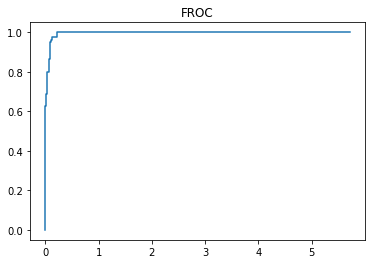

In [88]:
plt.title('FROC')
plt.plot(x_, y_)